<a href="https://colab.research.google.com/github/Nico-lly/Coursera_Capstone/blob/main/English_version_Capstone_store_projects.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Introduction
This notebook refers to the final design of the Coursera Aplied Data Science Capstone. To formulate the problem, and properly answer it in this project, we will be obliged to use the Foursquare API and the k-means clustering algorithm.

Clustering is the separation of data into groups of similarities, performed by unsupervised machine learning algorithms. Where, this grouping is based on the distance of the Cartesian distribution of points relative to the categories that were chosen as parameters for this similarity analysis.

K-means is an algorithm that groups data by means of centroids, where it is necessary to define a k number of clusters, for each cluster a centroid is assigned and each point of the distribution that belongs to a cluster is closer to its own centroid that of the others.

Foursquare is a city guide that allows users to register establishments, review them and assign grades. This information is available for consultation by any user through the Foursquare website and application and through the API. The site is mostly used by ordinary users to do various searches on locations, as it has a more friendly and interactive interface to access this data. But that same data can be searched for by programmers through its API, which is what we are going to do here.

##Problem
Our journey through this notebook consists of checking if it is possible to categorize clothing stores in groups, in the city of Recife - PE, through the similarity of establishments in the vicinity within a radius of 200 meters. In order to find a pattern of common establishments for each group, helping as one of the possible indicators to support the best choice of location for the opening of other stores, which have similarity with stores of any of these groups that were formed.

## Collection and pre-processing


Let's start by importing Pandas and Numpy, which are libraries for manipulating data in python. Where the first has structures and operations to manipulate tables and the second is a library of mathematical operations. The Pandas documentation can be seen here: https://pandas.pydata.org/docs/

Numpy documentation can be seen here: https://numpy.org

In addition to them, we will also import the Request library, which requests the data from the API. Its documentation can be seen here: https://geopy.readthedocs.io/

To consult geographic coordinates, we will import the Geocoders module and the Nominatim class from the Geopy library to find coordinates for the city of Recife. Its documentation can be seen here: https://docs.python-requests.org/en/master/

In [ ]:
import pandas as pd
import numpy as np
import requests
from geopy.geocoders import Nominatim

In [ ]:
geolocator = Nominatim(user_agent="nicollylira@live.com")
location = geolocator.geocode('Recife')
recife_latitude = location.latitude
recife_longitude = location.longitude

Starting the construction of our project, we will consult the geographic coordinates of the city of Recife, so that it is possible to use the Foursquare API and its 'search' ending to find, a limit of 50 clothing stores, within a radius of 6,000 meters from that coordinate.

To search only for clothing stores, we will use the key '4bf58dd8d48988d103951735', referring to this category of establishments (clothing stores). This and other category keys can be found on the Foursquare categories presentation and explanation page: https://developer.foursquare.com/docs/build-with-foursquare/categories

In [ ]:
CLIENT_ID = 'YD4RLCE3VNOTOJWKJJIYN50X0Z5QE22QMBLORO11QUENUYMC'
CLIENT_SECRET = 'WJ2KAZX5X5VNZL3K5TUQOXNBEYBXMLODJTABKX330DXYYTAR' 
VERSION = '20180605'
LIMIT = 200

In [ ]:
url = f'https://api.foursquare.com/v2/venues/search?client_id={CLIENT_ID}&client_secret={CLIENT_SECRET}&v={VERSION}&ll={recife_latitude},{recife_longitude}&radius={10000}&limit={LIMIT}&categoryId=4bf58dd8d48988d103951735'

In [ ]:
response = requests.get(url).json()['response']['venues']

To make it possible to manipulate the json file that we transport to our notebook, we need to view it and understand its keys and other structures. Thinking about making this visualization more friendly and organized, we imported the Pprint library, which provides us with this organization functionality. Its documentation can be seen here: https://docs.python.org/3/library/pprint.html

In [ ]:
import pprint

In [ ]:
pprint.pprint(response)

[{'categories': [{'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/apparel_',
                           'suffix': '.png'},
                  'id': '4bf58dd8d48988d103951735',
                  'name': 'Clothing Store',
                  'pluralName': 'Clothing Stores',
                  'primary': True,
                  'shortName': 'Apparel'}],
  'hasPerk': False,
  'id': '51840460498e1c12f42a58c9',
  'location': {'address': 'Shopping Boa Vista',
               'cc': 'BR',
               'city': 'Recife',
               'country': 'Brasil',
               'distance': 205,
               'formattedAddress': ['Shopping Boa Vista',
                                    'Recife, PE',
                                    'Brasil'],
               'labeledLatLngs': [{'label': 'display',
                                   'lat': -8.059215486963065,
                                   'lng': -34.88653447981707}],
               'lat': -8.059215486963065,
               'lng': -3

Having retrieved the necessary data from the API, we will store everything in a DataFrame to facilitate data manipulation with Python. We will also exclude columns that are not important for our analysis, keeping only the columns of the store's identification code, name, latitude and longitude.

The name of the ID column has been modified to help manipulate DataFrames later in this notebook.

In [ ]:
cloth_store = pd.json_normalize(data=response)

In [ ]:
print(cloth_store.shape)
cloth_store.head()

(48, 18)


,id,name,categories,referralId,hasPerk,location.address,location.lat,location.lng,location.labeledLatLngs,location.distance,location.cc,location.city,location.state,location.country,location.formattedAddress,location.postalCode,location.neighborhood,location.crossStreet
0,51840460498e1c12f42a58c9,Renner,"[{'id': '4bf58dd8d48988d103951735', 'name': 'C...",v-1619442856,False,Shopping Boa Vista,-8.059215,-34.886534,"[{'label': 'display', 'lat': -8.05921548696306...",205,BR,Recife,PE,Brasil,"[Shopping Boa Vista, Recife, PE, Brasil]",NaN,NaN,NaN
1,5191266f498e40cf33a1b1b6,Moda Atual Multmarcas,"[{'id': '4bf58dd8d48988d103951735', 'name': 'C...",v-1619442856,False,"Av. Fernando Simões Barbosa, 22, sala 1405, Ga...",-8.117771,-34.902088,"[{'label': 'display', 'lat': -8.11777122758263...",6867,BR,Recife,PE,Brasil,"[Av. Fernando Simões Barbosa, 22, sala 1405, G...",51020-390,"Boa Viagem, PE",NaN
2,4e45741ab61c03d0ccfe4eaa,Riachuelo,"[{'id': '4bf58dd8d48988d103951735', 'name': 'C...",v-1619442856,False,"Av. Conde da Boa Vista, 691",-8.059391,-34.887278,"[{'label': 'display', 'lat': -8.05939078352597...",288,BR,Recife,PE,Brasil,"[Av. Conde da Boa Vista, 691, Recife, PE, 5006...",50060-002,Centro,NaN
3,50e9b94fe4b05fbb80f1bfc5,Cauã modas,"[{'id': '4bf58dd8d48988d108951735', 'name': 'W...",v-1619442856,False,NaN,-8.047208,-34.917387,"[{'label': 'display', 'lat': -8.04720762581349...",3803,BR,Recife,PE,Brasil,"[Recife, PE, Brasil]",NaN,NaN,NaN
4,503be898e4b031fd8b0f6881,Talent,"[{'id': '4bf58dd8d48988d103951735', 'name': 'C...",v-1619442856,False,"Rua Martins Júnior, 38, Boa Vista",-8.062274,-34.884015,"[{'label': 'display', 'lat': -8.06227395786483...",430,BR,Recife,PE,Brasil,"[Rua Martins Júnior, 38, Boa Vista (Em frente ...",53060-110,NaN,Em frente ao Teatro do Parque


There are columns with information that we are not interested in for this analysis, we will then delete them from our DataFrame remaining only with the columns "cloth_store_id", "name", "location.lat" and "location.lng". Where:

* cloth_store_id: unique identification ID for each clothing store, so that, even being part of the same franchise and having the same name, each store in particular will have a different ID from the others, unique.

* name: Name of clothing stores.

* location.lat/location.lng: Geographic coordinates of each clothing store.

In [ ]:
cloth_store.drop(columns = ['categories','referralId','hasPerk','location.labeledLatLngs','location.distance','location.cc','location.city','location.state','location.country','location.formattedAddress','location.address','location.postalCode','location.neighborhood','location.crossStreet'], inplace = True)

In [ ]:
cloth_store = cloth_store. rename(columns={'id':'cloth_store_id'}) 	
print(cloth_store.shape)
cloth_store.tail()

(48, 4)


,cloth_store_id,name,location.lat,location.lng
43,55e5d4ad498e84aea8ef26bc,Le lieu,-8.033035,-34.909834
44,5293b7e4498e3051778ac817,Sergio's,-8.060763,-34.912387
45,50180d54e4b033fdafbd30d5,Antese,-8.045203,-34.892759
46,561d514a498e249eb1c5a3fc,Fêmea,-8.059369,-34.886189
47,4d939586484d6ea841757e30,GAmour,-8.052637,-34.886246


We will add the name of the neighborhoods for each entry, it will be important for future analysis. For this we will use the nominatim API. Next, let's insert the name of the neighborhoods in a column of the DataFrame

Nominatim documentation can be found here: https://nominatim.org/release-docs/develop/api/Reverse/

In [ ]:
name = []
for lat, lng in zip(cloth_store['location.lat'],cloth_store['location.lng']):
  request = requests.get(f'https://nominatim.openstreetmap.org/reverse?lat={lat}&lon={lng}&format=json').json()['address']['suburb']
  name.append(request)

In [ ]:
cloth_store ['neighborhood'] = name

In [ ]:
cloth_store.head()

,cloth_store_id,name,location.lat,location.lng,neighborhood
0,51840460498e1c12f42a58c9,Renner,-8.059215,-34.886534,Boa Vista
1,5191266f498e40cf33a1b1b6,Moda Atual Multmarcas,-8.117771,-34.902088,Boa Viagem
2,4e45741ab61c03d0ccfe4eaa,Riachuelo,-8.059391,-34.887278,Boa Vista
3,50e9b94fe4b05fbb80f1bfc5,Cauã modas,-8.047208,-34.917387,Torre
4,503be898e4b031fd8b0f6881,Talent,-8.062274,-34.884015,Boa Vista


  We will now make another call to the API, this time using the 'explore' endpoint to search, for each clothing store in the dataframe above, a maximum of 200 establishments and facilities within a radius of 200 meters away.

  Here the columns that interest us are just the name of these establishments and what type / category of Foursquare classification they belong to. Then we will extract this data and store everything in a DataFrame.

  In this DataFramde, we will also include the information already encapsulated in our notebook, from the clothing store ID. So that, each location that surrounds a certain clothing store, will receive the ID of that clothing store. This step is very important, as our goal is to analyze the clothing stores and, only in this way we will know which clothing store this establishment is close to.
In addition, maintaining this column is also important for joining DataFrames, since there are no published values ​​in the ID column after the groupby.
 

In [ ]:
import pprint

In [ ]:
categories_df = pd.DataFrame()
categories_list = []
for lat, long, id, neighborhood in zip(cloth_store['location.lat'], cloth_store['location.lng'], cloth_store['cloth_store_id'], cloth_store['neighborhood']):
  explore_url = f'https://api.foursquare.com/v2/venues/explore?client_id={CLIENT_ID}&client_secret={CLIENT_SECRET}&v={VERSION}&ll={lat},{long}&radius=200&limit={LIMIT}'
  response = requests.get(explore_url).json()['response']['groups'][0]['items']

  categories_list.append([(id,
                          v['venue']['name'],   
                          v['venue']['categories'][0]['name']) for v in response])
for lists in categories_list:
      for item in lists:
        df1 = pd.DataFrame(item).T
        df1.columns = ['cloth_store_id',  'name', 'category', ]
        categories_df = pd.concat([categories_df, df1], ignore_index = True)

In [ ]:
print(categories_df.shape)
categories_df.head()

(1143, 3)


,cloth_store_id,name,category
0,51840460498e1c12f42a58c9,Mitchell,Men's Store
1,51840460498e1c12f42a58c9,Nagem,Electronics Store
2,51840460498e1c12f42a58c9,Café São Braz Coffee Shop - Shopping Boa Vista,Café
3,51840460498e1c12f42a58c9,Julietto,Italian Restaurant
4,51840460498e1c12f42a58c9,Cacau Show,Chocolate Shop


To reduce our dimensionality, that is, the variables observed by the clustering algorithm, we will use an ontology available on Foursquare itself. For this, we will use the API again, this time with its 'categories' endpoint, to access and determine the larger categories of understanding to which each subcategory found above belongs.

We will store this information by grouping it in a dictionary structure, where the keys are the subcategories and the values ​​are their respective larger categories.

Finally, the information in the name column of the subcategories of the initial DataFrame of categories (categories_df), will be replaced by their larger categories using the ontological dictionary that was created.

In [ ]:
url = 'https://api.foursquare.com/v2/venues/categories?client_id={}&client_secret={}&v={}'.format(CLIENT_ID, CLIENT_SECRET,VERSION)

In [ ]:
response = requests.get(url).json()['response']['categories']

In [ ]:
ontology_dict = {}

for item in response:
  for category in item['categories']:
      ontology_dict[category['name']] = item['name']
      for item2 in category['categories']:
        ontology_dict[item2['name']] = item['name']
        for item3 in item2['categories']:
          ontology_dict[item3['name']] = item['name']
          for item4 in item3['categories']:
            ontology_dict[item4['name']] = item['name']

len(ontology_dict)

960

In [ ]:
ontology_dict

{'ATM': 'Shop & Service',
 'Abruzzo Restaurant': 'Food',
 'Acai House': 'Food',
 'Accessories Store': 'Shop & Service',
 'Acehnese Restaurant': 'Food',
 'Acupuncturist': 'Professional & Other Places',
 'Adult Boutique': 'Shop & Service',
 'Adult Education Center': 'Professional & Other Places',
 'Advertising Agency': 'Professional & Other Places',
 'Afghan Restaurant': 'Food',
 'African Restaurant': 'Food',
 'Agriturismo': 'Food',
 'Airfield': 'Travel & Transport',
 'Airport': 'Travel & Transport',
 'Airport Food Court': 'Travel & Transport',
 'Airport Gate': 'Travel & Transport',
 'Airport Lounge': 'Travel & Transport',
 'Airport Service': 'Travel & Transport',
 'Airport Terminal': 'Travel & Transport',
 'Airport Tram': 'Travel & Transport',
 'Alsatian Restaurant': 'Food',
 'Alternative Healer': 'Professional & Other Places',
 'American Restaurant': 'Food',
 'Amphitheater': 'Arts & Entertainment',
 'Andhra Restaurant': 'Food',
 'Anhui Restaurant': 'Food',
 'Animal Shelter': 'Professio

In [ ]:
categories_df['category'].replace(ontology_dict, inplace = True)

In [ ]:
categories_df

,cloth_store_id,name,category
0,51840460498e1c12f42a58c9,Mitchell,Shop & Service
1,51840460498e1c12f42a58c9,Nagem,Shop & Service
2,51840460498e1c12f42a58c9,Café São Braz Coffee Shop - Shopping Boa Vista,Food
3,51840460498e1c12f42a58c9,Julietto,Food
4,51840460498e1c12f42a58c9,Cacau Show,Shop & Service
...,...,...,...
1138,4d939586484d6ea841757e30,Ana Bispo Refeições,Food
1139,4d939586484d6ea841757e30,Casa Mecane - Café e Espaço Cultural,Arts & Entertainment
1140,4d939586484d6ea841757e30,Editora Ática,Shop & Service
1141,4d939586484d6ea841757e30,Lanchonete-escola Senac,Food


In [ ]:
#DEBUG#

#for i in categories_df['category']:
#  if not i in temp_categories_list:
#    temp = categories_df[categories_df['category'] == i]
#    #categories_df['category'].drop(temp, axis =1, inplace = True)

#print(temp)

We now have the necessary data for clothing stores and locations that surround them within a radius of 100 meters, so we need to merge all of that information into a single DataFrame through the clothing store's ID column.
In this step, we will also modify the name of the columns to facilitate understanding, since we have information about two different things together.

In [ ]:
complete_df = pd.merge(categories_df, cloth_store, how = 'left', on = 'cloth_store_id')

In [ ]:
complete_df.columns = ['cloth_store_id', 'close_venue_name', 'close_venue_category', 'cloth_store_name', 'cloth_store_lat', 'cloth_store_lng', 'cloth_store_neighborhood', ]
complete_df.head()

,cloth_store_id,close_venue_name,close_venue_category,cloth_store_name,cloth_store_lat,cloth_store_lng,cloth_store_neighborhood
0,51840460498e1c12f42a58c9,Mitchell,Shop & Service,Renner,-8.059215,-34.886534,Boa Vista
1,51840460498e1c12f42a58c9,Nagem,Shop & Service,Renner,-8.059215,-34.886534,Boa Vista
2,51840460498e1c12f42a58c9,Café São Braz Coffee Shop - Shopping Boa Vista,Food,Renner,-8.059215,-34.886534,Boa Vista
3,51840460498e1c12f42a58c9,Julietto,Food,Renner,-8.059215,-34.886534,Boa Vista
4,51840460498e1c12f42a58c9,Cacau Show,Shop & Service,Renner,-8.059215,-34.886534,Boa Vista


In preparation for clustering, we will use the Categories column from nearby locations (which is the factor by which we will cluster our clothing stores) and transform it into one hot encoding.

One hot encoding consists of transforming the information into outputs of 0 or 1 that indicate false or true, respectively, for each category of columns.
If our first entry corresponds to a category, it will be marked with the number 1 while the other columns / categories will be marked with the number 0.

We will do this, with the intention of counting how many establishments in each category there are in the vicinity of each clothing store, this will be clearer in the topic below.

To better visualize our problem, the name columns of the establishment near the clothing stores and their respective foursquare categories were necessary. But for this step, in which we are going to prepare our data for clustering by categories, we will create a dataframe that ignores that data.

In [ ]:
categories_onehot = pd.get_dummies(complete_df[['close_venue_category']], prefix="", prefix_sep="")
categories_onehot['cloth_store_id'] = complete_df['cloth_store_id']

In [ ]:
categories_onehot.head()

,Arts & Entertainment,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Shop & Service,Travel & Transport,cloth_store_id
0,0,0,0,0,0,1,0,51840460498e1c12f42a58c9
1,0,0,0,0,0,1,0,51840460498e1c12f42a58c9
2,0,1,0,0,0,0,0,51840460498e1c12f42a58c9
3,0,1,0,0,0,0,0,51840460498e1c12f42a58c9
4,0,0,0,0,0,1,0,51840460498e1c12f42a58c9


Now we are going to reposition the clothing store identification code column, and group all the same codes together by adding the values ​​of the categories. As we transform our categories into Boolean values ​​above, we can do this to easily count, adding all zeros and ones for each unique ID.

With that, we will find how many locations in the same category exist within a radius of 100 meters from each clothing store we are analyzing. We will assign this result to a new DataFrame.

In [ ]:
categories_grouped = categories_onehot.groupby('cloth_store_id').sum().reset_index()

In [ ]:
print(categories_grouped.shape)
categories_grouped.tail()

(48, 8)


,cloth_store_id,Arts & Entertainment,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Shop & Service,Travel & Transport
43,561d514a498e249eb1c5a3fc,2,21,3,0,0,11,0
44,576c3c79498e43657ca5d05d,2,2,0,1,0,1,0
45,5798f605498e8e0d5165b068,0,14,0,3,0,13,0
46,58cc161b23188e1a22638118,1,10,1,1,0,2,0
47,59c6541450a6f05ddce87218,0,8,0,2,0,3,2


##clustering

We will, once again, start a new stage by importing the libraries necessary to carry it out.

From ScikitLeaning we will import the KMeans Class from the Cluster module, to create a KMeans object that applies the clustering algorithm with the same name. Its documentation can be seen here: https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html

And, from the same library, we will import the Silhouette_score Class from the Metrics module, which allows us to calculate the silhouette metrics for each cluster, we will talk more about it below. Its documentation can be seen here: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html

Finally, we will import the Pyplot module from the Matplotlib library to plot graphs. Its documentation can be seen here: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.html

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score


We will once again remove the identification column from clothing stores, as it is not interesting that our algorithm takes this into account when grouping our entry data for categories close to those stores.

Before starting the machine learning process, we will place our data on the same scale of values, in order to improve the metrics of the algorithm. For this case, we will use Normalization scaling, placing our values ​​on a scale between -1 and 1.

In [ ]:
categories_clustering = categories_grouped.drop('cloth_store_id', 1)

In [ ]:
categories_clustering = (categories_clustering-categories_clustering.min())/(categories_clustering.max()-categories_clustering.min())

In [ ]:
print(categories_clustering.shape)
categories_clustering.head()

(48, 7)


,Arts & Entertainment,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Shop & Service,Travel & Transport
0,1.00,1.000,0.00,0.000000,0.0,0.966667,0.0
1,0.25,0.150,0.25,0.000000,0.0,0.200000,0.5
2,1.00,0.600,0.00,0.000000,0.0,0.433333,0.0
3,0.00,0.400,0.25,0.333333,0.0,0.566667,0.5
4,0.00,0.375,0.25,0.666667,0.0,0.300000,0.5


We will once again remove the identification column from clothing stores, as it is not interesting that our algorithm takes this into account when grouping our entry data for categories close to those stores.

As a parameter, kmeans asks for the number of groups or clusters that we would like to separate our data from.
But, indicating the wrong number of clusters can make our separation unsupervised by similarity of variance (clustering) little precise, either because it has too many groups that generalize too little or groups of less that cannot separate the groups by their respective nuances.
We can try to solve this problem by finding an optimal number of clusters using two Heuristic methods: the elbow method and the silhouette method.

The elbow method graphically presents, with the help of a repetition structure (for), the data variance for each number of clusters (inertia). The number of clusters is chosen in this graph from the point at which the y-axis begins to stabilize or does not have such a large variation, we know that there is no longer such a large variance between the clusters.

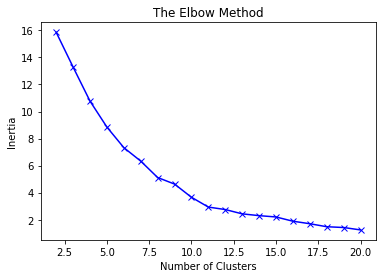

In [ ]:
inertia = []
 
for i in range(2, 21):
  kmeans_elbow = KMeans(n_clusters = i, random_state=7, n_init = 100, init ='random')
  kmeans_elbow.fit(categories_clustering)
  inertia.append(kmeans_elbow.inertia_) 

plt.plot(range(2, 21), inertia, 'bx-')
plt.title('The Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

The silhouette coefficient calculates the similarity of each point with the centroid of its own cluster (cohesion) in relation to the difference with other points of other clusters (separation). Checking beyond the cohesion of the cluster (distance to its respective centroid), the distance between one cluster and another (distance between each point of a cluster and another). This coefficient is determined on a scale that varies between -1 and 1, where 1 represents the best separation between the groups, 0 can be seen as a starting point or no separation and -1 a bad separation.

With the help of a 'for' loop we will calculate this coefficient for several possible numbers of clusters and we will plot the average of that coefficient in a simple line graph to more intuitively visualize the optimal number of clusters.

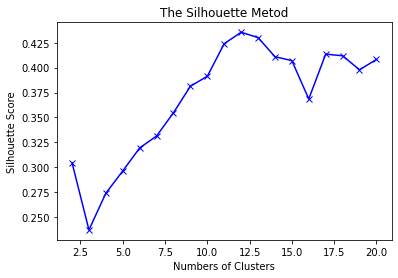

In [ ]:
sil = []
for k in range(2, 21):
  kmeans_sil = KMeans( n_clusters = k, random_state = 7, n_init =100, init ='random')
  kmeans_sil.fit(categories_clustering)
  labels = kmeans_sil.labels_
  sil.append(silhouette_score(categories_clustering, labels, metric = 'euclidean'))

plt.plot(range(2,21), sil, 'bx-')
plt.title('The Silhouette Metod')
plt.xlabel('Numbers of Clusters')
plt.ylabel('Silhouette Score')
plt.show()

The silhouette coefficient calculates the similarity of each point with the centroid of its own cluster (cohesion) in relation to the difference with other points of other clusters (separation). Checking beyond the cohesion of the cluster (distance to its respective centroid), the distance between one cluster and another (distance between each point of a cluster and another). This coefficient is determined on a scale that varies between -1 and 1, where 1 represents the best separation between the groups, 0 can be seen as a starting point or no separation and -1 a bad separation.

Our elbow graph was inconclusive, while the silhouette graph points to a very large number of clusters in relation to the amount of our data.
In this way, I assumed a number of 5 clusters because it is the best silhouette index before the score goes up indefinitely, and because, below, we can see that it is the number of clusters that more evenly distributes the number of stores among the clusters.

To improve our result, we are going to define a n_init of 100 so that the algorithm runs clustering 100 times with centroides initially distributed in different positions, and choose the best way of initialization for this case.

We will then perform the clustering with five groups, and then add labels that indicate the number of the cluster to which each entry or store belongs.


In [ ]:
kclusters = 5  
kmeans = KMeans(n_clusters=kclusters, random_state=7, init ='random', n_init =100).fit(categories_clustering)
clusters = kmeans.labels_
centers = kmeans.cluster_centers_

In [ ]:
from sklearn.metrics import silhouette_samples, silhouette_score


In [ ]:
len(clusters)

48

In [ ]:
categories_grouped['clusters'] = clusters

We will now see the name of all columns and delete all, except the clothing store identification column and the column with the cluster information for each entry.

This step is necessary for a better visualization of this clustering data in a DataFrame.

In [ ]:
categories_grouped.columns

Index(['cloth_store_id', 'Arts & Entertainment', 'Food', 'Nightlife Spot',
       'Outdoors & Recreation', 'Professional & Other Places',
       'Shop & Service', 'Travel & Transport', 'clusters'],
      dtype='object')

In [ ]:
 id_cluster_df = categories_grouped.drop(['Arts & Entertainment', 'Food', 'Nightlife Spot',
       'Outdoors & Recreation', 'Professional & Other Places',
       'Shop & Service', 'Travel & Transport'], axis =1)

In [ ]:
id_cluster_df.head()

,cloth_store_id,clusters
0,4bff020108ead13a3bb8ade4,3
1,4c8ea4d258668cfafbb9d3ec,2
2,4cb9ddab035d236a1ea0d64e,3
3,4ccebfccee23a143c5c92da8,0
4,4d08bc4584ec224b71222b62,0


To build our final DataFrame, we will now join the small DataFrame created above (id_cluster_df) by the clothing store identification column (id_cluster_df) and the first clothing store information DataFrame (cloth_store).

In this way, we have the store's name and unique id, which cluster it belongs to and its geographic coordinates.

In [ ]:
Final_df = pd.merge(id_cluster_df, complete_df, how = 'left', on = 'cloth_store_id') 

In [ ]:
Final_df.head()

,cloth_store_id,clusters,close_venue_name,close_venue_category,cloth_store_name,cloth_store_lat,cloth_store_lng,cloth_store_neighborhood
0,4bff020108ead13a3bb8ade4,3,Outback Steakhouse,Food,Renner,-8.118181,-34.904588,Boa Viagem
1,4bff020108ead13a3bb8ade4,3,Shopping Recife,Shop & Service,Renner,-8.118181,-34.904588,Boa Viagem
2,4bff020108ead13a3bb8ade4,3,Camarada Camarão,Food,Renner,-8.118181,-34.904588,Boa Viagem
3,4bff020108ead13a3bb8ade4,3,Saraiva MegaStore,Shop & Service,Renner,-8.118181,-34.904588,Boa Viagem
4,4bff020108ead13a3bb8ade4,3,Imaginarium,Shop & Service,Renner,-8.118181,-34.904588,Boa Viagem


In [ ]:
Final_df.columns

Index(['cloth_store_id', 'clusters', 'close_venue_name',
       'close_venue_category', 'cloth_store_name', 'cloth_store_lat',
       'cloth_store_lng', 'cloth_store_neighborhood'],
      dtype='object')

We will create a list of unique neighborhoods in which our clothing stores are located, and indicate the "Average Nominal Monthly Income of Households" according to IBGE for each neighborhood.
This value refers to the average monthly nominal income per household unit in each neighborhood, and is expressed in reais. Nominal income is the sum of any cash inflows, not just formally documented amounts. On this website there is no information on whether this nominal income is per capita or not, that is, the sum of the total income divided by the number of residents of the residence.

This data will be imported into our notebook manually, as there is no standardization of HTML tags that allows webscrapping of all information without having to carry out inspections at each url, thus losing the possibility of automation.

These data can be found at: http://www2.recife.pe.gov.br

In [ ]:
Final_df['cloth_store_neighborhood'].unique()

array(['Boa Viagem', 'Tamarineira', 'Santo Amaro', 'Boa Vista', 'Pina',
       'Espinheiro', 'Torre', 'Casa Amarela', 'Imbiribeira', 'Aflitos',
       'UR-02 - Vila Cohab', 'Areias', 'Prado', 'Iputinga', 'Jaqueira',
       'Parnamirim'], dtype=object)

In [ ]:
income_values = {'Boa Viagem': 7.108, 'Tamarineira': 7.904, 'Santo Amaro': 1.892, 'Boa Vista': 3.618, 'Pina': 2.446, 'Espinheiro': 7.299, 
                 'Torre':4.827,'Casa Amarela':4.236, 'Imbiribeira':2.108, 'Aflitos':1.028, 'UR-02 - Vila Cohab': 1.182, 'Areias': 1.941, 
                 'Prado': 2.617,  'Iputinga': 2.045, 'Jaqueira': 11.339, 'Parnamirim': 10.712}

In [ ]:
df_viz = pd.merge(id_cluster_df, cloth_store, how = 'left', on = 'cloth_store_id').reset_index()

In [ ]:

for itens in df_viz['neighborhood']:
  for key, values in income_values.items():  
    if itens == key:
      df_viz['neighborhood_income'] = values
    else:
        continue


df_viz.head()

,index,cloth_store_id,clusters,name,location.lat,location.lng,neighborhood,neighborhood_income
0,0,4bff020108ead13a3bb8ade4,3,Renner,-8.118181,-34.904588,Boa Viagem,7.108
1,1,4c8ea4d258668cfafbb9d3ec,2,Dona Santa Santo Homem,-8.111335,-34.893834,Boa Viagem,7.108
2,2,4cb9ddab035d236a1ea0d64e,3,C&A,-8.119160,-34.906346,Boa Viagem,7.108
3,3,4ccebfccee23a143c5c92da8,0,Riachuelo,-8.119676,-34.902703,Boa Viagem,7.108
4,4,4d08bc4584ec224b71222b62,0,Casas José Araújo,-8.032674,-34.903750,Tamarineira,7.108


The number five of clusters was chosen for our problem, as it was the one that presented a more equal distribution of stores among the clusters. As we can see in the DataFrame below:

In [ ]:
df_viz.groupby('clusters').count()

,index,cloth_store_id,name,location.lat,location.lng,neighborhood,neighborhood_income
clusters,,,,,,,
0,9,9,9,9,9,9,9
1,6,6,6,6,6,6,6
2,19,19,19,19,19,19,19
3,6,6,6,6,6,6,6
4,8,8,8,8,8,8,8


##Data Analisys

Before starting to analyze each cluster, let's see where each clothing store and its respective clusters are located on a map. In this way, we will mark each cluster with different colors and observe its geographic distribution.

For this task we will import some more libraries. Firstly Folium, which is a library for viewing geospatial data on a map, using latitude and longitude. Its documentation can be seen here: https://python-visualization.github.io/folium/

In [ ]:
import folium
import matplotlib.cm as cm
import matplotlib.colors as colors

In [ ]:

map_stores = folium.Map(location=[recife_latitude, recife_longitude], zoom_start=11)

rainbow = {0:'red', 1:'blue', 2:'green', 3:'yellow', 4:'purple', 5:'orange', 6:'white', 7:'black', 8:'pink', 9:'turquoise'}

# add markers to map
markers_colors = []
for lat, lon, poi, cluster in zip(Final_df['cloth_store_lat'], Final_df['cloth_store_lng'], Final_df['cloth_store_name'], Final_df['clusters']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster],
        fill=True,
        fill_color=rainbow[cluster],
        fill_opacity=0.7).add_to(map_stores)
       
map_stores

We will count how many times each category appears in each of the clusters and transform this information into a DataFrame.

There are clusters with a much larger number of stores, and consequently of establishments that surround these stores, therefore, it is difficult to make a fair comparison between the categories most found in each cluster.

To solve this problem we will create a new column with the percentage of the amount column, staggering the count of the values ​​of the clusters.
In this way, we will identify not only the most significant categories for each cluster, but also, we will be able to proportionally compare the difference in the quantity of these categories between the clusters.

###Cluster 4


Group 4 has eight stores, the vast majority of which are located in the central region of the city of Recife, in the Boa Vista neighborhood. However, it still has two stores located further south of the city and only one in the north in the neighborhood of Aflitos. The average monthly nominal income per household, in the neighborhoods in which the stores in this cluster are located, vary widely, starting in a thousand and reaching up to seven thousand reais. It is also the cluster that has the highest percentage of 'Nightlife Spot' in relation to the other groups.

In [ ]:
cluster4_df = pd.DataFrame(Final_df[Final_df['clusters'] == 4].value_counts('close_venue_category')).reset_index()
cluster4_df.columns = ['Category', 'amount']

temp4 = []
for n in cluster4_df['amount']: 
  temp4.append((n/cluster4_df['amount'].sum()*100).round(2))


cluster4_df['percentage']= temp4
cluster4_df

,Category,amount,percentage
0,Food,116,52.25
1,Shop & Service,65,29.28
2,Nightlife Spot,22,9.91
3,Arts & Entertainment,11,4.95
4,Outdoors & Recreation,5,2.25
5,Travel & Transport,2,0.90
6,Professional & Other Places,1,0.45


In [ ]:
df4 = Final_df[Final_df['clusters'] == 4]
df4['cloth_store_neighborhood'].unique()

array(['Boa Vista', 'Pina', 'Aflitos', 'Boa Viagem'], dtype=object)

In [ ]:
sum4 = 0

for i in df_viz['clusters']:
  if i == 4:
    sum4 = sum4+1 

sum4

8

###Cluster 3


It has six clothing stores, all within shopping malls, located in the south zone of Recife, in the neighborhoods of Boa Viagem and Pina, which have a value of the average monthly nominal income of households of seven and two thousand reais respectively. Another similarity between the region is the fact that both are coastal regions, with beaches even neighboring.
These malls also have a pattern among themselves: they are the largest malls in the city.
With this group, we can assume that the layout of clothing stores in shopping malls in this area of ​​the city, has a pattern of establishments in the surroundings.

In [ ]:
cluster3_df = pd.DataFrame(Final_df[Final_df['clusters'] == 3].value_counts('close_venue_category')).reset_index()
cluster3_df.columns = ['Category', 'amount']

temp3 = []
for n in cluster3_df['amount']: 
  temp3.append((n/cluster3_df['amount'].sum()*100).round(2))


cluster3_df['percentage']= temp3
cluster3_df

,Category,amount,percentage
0,Food,177,54.13
1,Shop & Service,123,37.61
2,Arts & Entertainment,23,7.03
3,Outdoors & Recreation,2,0.61
4,Nightlife Spot,2,0.61


In [ ]:
df3 = Final_df[Final_df['clusters'] == 3]
df3['cloth_store_neighborhood'].unique()

array(['Boa Viagem', 'Pina'], dtype=object)

In [ ]:
sum3 = 0

for i in df_viz['clusters']:
  if i == 3:
    sum3 = sum3+1

sum3

6

###Cluster 2

There are nineteen stores classified as part of that cluster. With a very varied geographic spread, without the presence of an identifiable pattern in this respect. However, the value of the average monthly nominal income of households has a smaller variance between them, with the exception of the Boa Vista neighborhood, this socioeconomic metric in this cluster varies between one thousand and two thousand reais. With this, it is also the cluster with the lowest average monthly nominal income, indicating that this is the pattern of clothing store surroundings for neighborhoods in Recife where residents have, on average, a lower purchasing power.




In [ ]:
cluster2_df = pd.DataFrame(Final_df[Final_df['clusters'] == 2].value_counts('close_venue_category')).reset_index()
cluster2_df.columns = ['Category', 'amount']

temp2 = []
for n in cluster2_df['amount']: 
  temp2.append((n/cluster2_df['amount'].sum()*100).round(2))


cluster2_df['percentage']= temp2
cluster2_df

,Category,amount,percentage
0,Food,103,54.79
1,Shop & Service,50,26.60
2,Arts & Entertainment,10,5.32
3,Outdoors & Recreation,9,4.79
4,Nightlife Spot,9,4.79
5,Travel & Transport,7,3.72


In [ ]:
df2 = Final_df[Final_df['clusters'] ==2]
df2['cloth_store_neighborhood'].unique()

array(['Boa Viagem', 'Santo Amaro', 'Espinheiro', 'Casa Amarela', 'Torre',
       'Imbiribeira', 'UR-02 - Vila Cohab', 'Areias', 'Prado', 'Iputinga'],
      dtype=object)

In [ ]:
sum2 = 0

for i in df_viz['clusters']:
  if i == 2:
    sum2 = sum2+1

sum2

19

###Cluster 1

This group has six stores, the largest concentration in the center of Recife, in the Santo Amaro neighborhood, within the Tacaruna shopping center. Only two stores are located in the southern region of Recife in the neighborhoods of Pina and Boa Viagem. The value of the average monthly nominal income of households in these last two neighborhoods is two and seven thousand, respectively. The neighborhood of Santo Amaro is around a thousand, but there are relativizations that can be made due to the fact that all these stores are inside a mall.
It is also important to note that, despite being stores in a shopping mall, they were not grouped in cluster 3. The most likely hypothesis is the indication of different categories of establishments available in shopping malls according to the region, since cluster 3 has a percentage much higher in the 'Arts & Entertainment' category and slightly higher in the 'Outdoors & Recreation' category. But another hypothesis is just a different arrangement of clothing stores between these malls.

In [ ]:
cluster1_df = pd.DataFrame(Final_df[Final_df['clusters'] == 1].value_counts('close_venue_category')).reset_index()
cluster1_df.columns = ['Category', 'amount']

temp1 = []
for n in cluster1_df['amount']: 
  temp1.append((n/cluster1_df['amount'].sum()*100).round(2))


cluster1_df['percentage']= temp1
cluster1_df

,Category,amount,percentage
0,Food,117,50.87
1,Shop & Service,108,46.96
2,Nightlife Spot,2,0.87
3,Arts & Entertainment,2,0.87
4,Outdoors & Recreation,1,0.43


In [ ]:
df1 = Final_df[Final_df['clusters'] == 1]
df1['cloth_store_neighborhood'].unique()

array(['Santo Amaro', 'Boa Vista', 'Pina'], dtype=object)

In [ ]:
sum1 = 0

for i in df_viz['clusters']:
  if i == 1:
    sum1 = sum1+1

sum1

6

###Cluster 0

It has nine stores, all of which are completely concentrated in the south and north of the city, with no store in the center and in other regions.
In this cluster, in addition to the first two categories present in a higher percentage in all clusters, "Travel & Transport" establishments stand out, followed by a also good index of "Outdoors & Recreation".
All the neighborhoods in which the stores in this cluster are located also have a high value of the average monthly nominal income of Households that vary between 4 and 11 thousand reais, thus being a cluster of stores aimed at the middle and upper class.

In [ ]:
cluster0_df = pd.DataFrame(Final_df[Final_df['clusters'] == 0].value_counts('close_venue_category')).reset_index()
cluster0_df.columns = ['Category', 'amount']

temp0 = []
for n in cluster0_df['amount']: 
  temp0.append((n/cluster0_df['amount'].sum()*100).round(2))


cluster0_df['percentage']= temp0
cluster0_df

,Category,amount,percentage
0,Food,80,45.45
1,Shop & Service,65,36.93
2,Outdoors & Recreation,20,11.36
3,Travel & Transport,6,3.41
4,Nightlife Spot,5,2.84


In [ ]:
df0 = Final_df[Final_df['clusters'] ==0]
df0['cloth_store_neighborhood'].unique()

array(['Boa Viagem', 'Tamarineira', 'Torre', 'Jaqueira', 'Parnamirim',
       'Pina'], dtype=object)

In [ ]:
sum0 = 0

for i in df_viz['clusters']:
  if i == 0:
    sum0 = sum0+1

sum0

9

##Conclusion


Before focusing on the discussions on the results of this study, I would like to highlight two pieces of information relevant to the understanding of this result as a whole.

The first point is the difficulty of finding data referring to neighborhoods in the city of Recife, the open data sources found had more general data related to the city as a whole, with entries without divisions or identification variables by neighborhood. In view of this, I performed a webscrapping of the Recife City Hall website, but it is still a long way from a robust database.

The second and last is that unfortunately, Foursquare has gradually lost popularity in Brazil, and today there are few records of establishments still registered and users feeding the platform.
Thus, an alternative that can answer the question proposed in this work, is the collection of more data, both from clothing stores, as well as other data sources for purposes of comparison and cross-checking with the main data of the stores.

That said, let's look at the results. With a brief observation of the percentages of categories per cluster, it is possible to determine that all of them have mostly establishments in the category "Food" and "Shop & Service". Indicating that all clothing stores, according to data and techniques used in this study, regardless of the region of the city of Recife, will have a significant number of establishments of this type around, with more than 50% of the total of nearby establishments for all clusters.

It is possible to glimpse slight indications of possible patterns in some of the clusters grouped here, for example, clusters that only appear in more valued regions of the city or only inside shopping malls, as was the case with some. But, based on the quantity and quality of data available here, for the application of this methodology in specific, the arguments of similarities that arise are still very fragile. It can be concluded that, with the k-means clustering algorithm and the data used, it is not possible to identify a pattern of clothing store surroundings for each cluster.




##References


- Elbow and Silhouette method: https://ichi.pro/pt/metodo-da-silhueta-melhor-do-que-o-metodo-do-cotovelo-para-encontrar-aglomerados-ideais-61080390822033

- Taste of New York city neighbohoods: https://towardsdatascience.com/exploring-the-taste-of-nyc-neighborhoods-1a51394049a4

- Clustering of São Paulo subway: https://medium.com/@felipe.testaa/unsupervised-machine-learning-kmeans-clustering-of-s%C3%A3o-paulo-subway-stations-using-foursquare-c5101727dd85